/var/folders/l9/7x451g6n2y91ptkr7k4fy6fr0000gn/T/ipykernel_16760/4007888202.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_treated_group['y_before'] = matched_treated_group['y']
/var/folders/l9/7x451g6n2y91ptkr7k4fy6fr0000gn/T/ipykernel_16760/4007888202.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_treated_group['y_after'] = matched_treated_group['y'] + np.random.normal(5, 5, len(matched_treated_group))  # 模拟干预后的变化


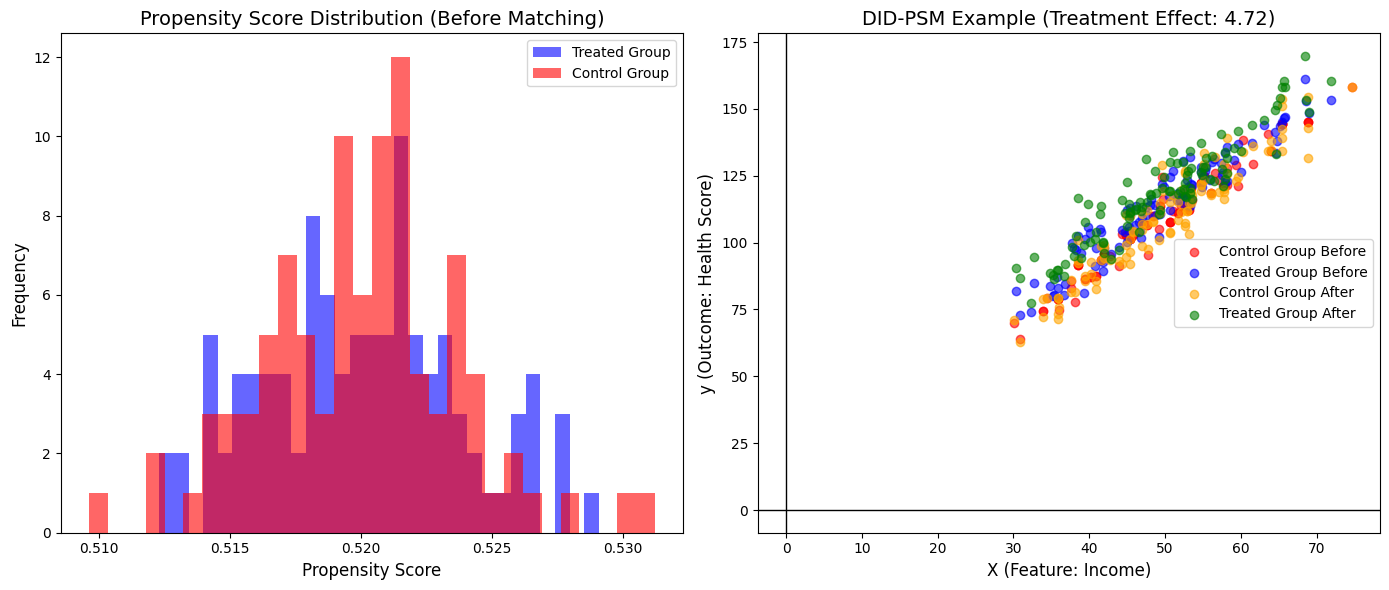

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# 设置随机种子
np.random.seed(42)

# 模拟数据
n = 200  # 样本数
time_points = 2  # 时间点（干预前和干预后）

# 生成数据
X = np.random.normal(loc=50, scale=10, size=(n, 1))  # 特征变量
treatment = np.random.binomial(1, 0.5, n)  # 处理组标签
y = 10 + 2 * X.squeeze() + treatment * 5 + np.random.normal(0, 5, n)  # 假设干预效应为5

# 将数据组合成 DataFrame
df = pd.DataFrame({'X': X.squeeze(), 'y': y, 'treatment': treatment})

# -------------------------------
# PSM：倾向得分匹配
# 使用Logistic回归模型来估计倾向得分
model_psm = LogisticRegression()
model_psm.fit(df[['X']], df['treatment'])
df['propensity_score'] = model_psm.predict_proba(df[['X']])[:, 1]

# 使用最近邻匹配（Nearest Neighbors）来执行匹配
nn = NearestNeighbors(n_neighbors=1)
nn.fit(df[df['treatment'] == 0][['propensity_score']])  # 对照组
distances, indices = nn.kneighbors(df[df['treatment'] == 1][['propensity_score']])  # 处理组

# 匹配后的对照组和处理组
matched_control_group = df[df['treatment'] == 0].iloc[indices.flatten()]
matched_treated_group = df[df['treatment'] == 1]

# -------------------------------
# DID：双重差分分析
# 计算干预前后的变化
matched_control_group['y_before'] = matched_control_group['y']
matched_treated_group['y_before'] = matched_treated_group['y']

matched_control_group['y_after'] = matched_control_group['y'] + np.random.normal(0, 5, len(matched_control_group))  # 模拟干预后的变化
matched_treated_group['y_after'] = matched_treated_group['y'] + np.random.normal(5, 5, len(matched_treated_group))  # 模拟干预后的变化

# 计算双重差分（DID）效应
did_effect = (matched_treated_group['y_after'].mean() - matched_treated_group['y_before'].mean()) - \
             (matched_control_group['y_after'].mean() - matched_control_group['y_before'].mean())

# -------------------------------
# 可视化
plt.figure(figsize=(14, 6))

# 子图1：倾向得分匹配前后协变量的分布
plt.subplot(1, 2, 1)
plt.hist(df[df['treatment'] == 1]['propensity_score'], bins=30, alpha=0.6, label='Treated Group', color='b')
plt.hist(df[df['treatment'] == 0]['propensity_score'], bins=30, alpha=0.6, label='Control Group', color='r')
plt.title('Propensity Score Distribution (Before Matching)', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# 子图2：双重差分效果（干预前后变化）
plt.subplot(1, 2, 2)
plt.scatter(matched_control_group['X'], matched_control_group['y_before'], label="Control Group Before", alpha=0.6, color='r')
plt.scatter(matched_treated_group['X'], matched_treated_group['y_before'], label="Treated Group Before", alpha=0.6, color='b')
plt.scatter(matched_control_group['X'], matched_control_group['y_after'], label="Control Group After", alpha=0.6, color='orange')
plt.scatter(matched_treated_group['X'], matched_treated_group['y_after'], label="Treated Group After", alpha=0.6, color='green')

plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title(f'DID-PSM Example (Treatment Effect: {did_effect:.2f})', fontsize=14)
plt.xlabel('X (Feature: Income)', fontsize=12)
plt.ylabel('y (Outcome: Health Score)', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()
